# Lesson 1.4: Sensitivity Analysis
$_\text{Metahuristics and Optimization | D.J.D. Lopez | 2026}$

**Sensitivity analysis** studies how the optimal solution and objective value of an optimization model change in response to perturbations of its parameters (e.g., costs, demands, and resource capacities). It asks, in a precise way, how robust a nominally optimal solution is when the underlying data are varied within plausible ranges. In applications, this information is essential for identifying which parameters are critical, which are comparatively benign, and how much deviation the system can tolerate before the optimal decision or its value changes materially.

Sensitivity analysis can be performed by hand using simplex tableaus, dual problems, and linear algebra to compute allowable ranges and verify complementary slackness. This is valuable for building intuition and understanding the theory. However, for realistic problem sizes and modern MILP models, Python-based automation becomes essential.

Python greatly facilitates sensitivity analysis by automating both the extraction of solver information and the execution of systematic experiments. Through libraries such as CVXPY, it can access dual variables, reduced costs, and other sensitivity-related quantities directly from the solver; through simple loops and data structures, it can implement parametric studies in which parameters are perturbed, problems are re-solved, and the resulting changes in solutions and objective values are recorded and visualized.

## 1. Why Sensitivity Analysis Matters

1. **Robustness and confidence.** Real optimization models contain uncertainty. Sensitivity analysis quantifies how far a solution can flex before it ceases to be optimal or even feasible. This is essential when stakes are high (e.g., capital investment, supply chain design, energy dispatch).

2. **Insight into solution structure.** Sensitivity quantities such as reduced costs, shadow prices, and allowable ranges reveal which parts of the solution are truly critical. A shadow price of zero on a constraint indicates that additional capacity in that resource has no marginal value, whereas a large shadow price indicates a binding bottleneck. This structural insight guides strategic decisions about where to invest to improve performance.

3. **Efficient re-optimization.** Classical LP sensitivity theory (allowable ranges, the 100\% rule) makes it possible to answer many “what-if” questions without re-solving the problem. For large LPs, this avoids expensive recomputation. For smaller problems or more complex, simultaneous perturbations, parametric re-solving via programming becomes a practical complement to the analytic theory.

4. **Managerial value.** Optimization is not only about finding one best plan; it is about understanding the trade-offs and robustness of that plan. Sensitivity analysis translates technical outputs into managerial insight: which resource should be expanded, which cost reduction target matters most, and how sensitive profits are to demand forecasts.

In [1]:
import numpy as np
import cvxpy as cp

## Problem Case: Production Planning

Consider a small manufacturing firm that produces two products using two limited resources: raw material and labor. The firm wishes to decide how many units of each product to produce in order to maximize total profit, subject to resource constraints.

**Decision variables:**

$$
x_1 = \text{units of Product 1 to produce}, \quad
x_2 = \text{units of Product 2 to produce}.
$$

**Profit and resource usage:**

- Product 1: profit $= 6$ per unit; uses 1 unit of material and 2 hours of labor.  
- Product 2: profit $= 9$ per unit; uses 1 unit of material and 4 hours of labor.  

**Available resources:**

- Material A: 100 units.  
- Labor: 300 hours.  

**LP formulation**

Objective (maximize profit):

$$
\max\ 6x_1 + 9x_2
$$

Subject to:

$$
x_1 + x_2 \le 100 \quad \text{(material constraint)},
$$

$$
2x_1 + 4x_2 \le 300 \quad \text{(labor constraint)},
$$

$$
x_1 \ge 0,\quad x_2 \ge 0.
$$

This model will serve as the base case for all subsequent sensitivity analysis (reduced costs, shadow prices, allowable ranges, 100\% rule, and LP–MILP comparisons).

In [2]:
x1 = cp.Variable(name="x1", nonneg=True)
x2 = cp.Variable(name="x2", nonneg=True)

constraints = [
    x1 + x2 <= 100,      # Material A
    2 * x1 + 4 * x2 <= 300,  # Labor
]

objective = cp.Maximize(6 * x1 + 9 * x2)

problem = cp.Problem(objective, constraints)
problem.solve()

print("Status:", problem.status)
print("Optimal value:", problem.value)
print("x1* =", x1.value)
print("x2* =", x2.value)

Status: optimal
Optimal value: 749.9999978418215
x1* = 49.99999955711787
x2* = 50.00000005545714


## 2. Functionizing the Model and Defining Parameter Ranges

Before analyzing sensitivity, it is useful to express the LP as a Python function that takes model parameters as inputs and returns the optimal solution. This makes it easy to run many “what-if” cases programmatically.

We treat profits and resource capacities as parameters:

- Profit coefficients: $c_1, c_2$
- Material capacity: $M$
- Labor capacity: $L$

The LP becomes:

$$
\max\ c_1 x_1 + c_2 x_2
$$

Subject to

$$
x_1 + x_2 \le M,\quad
2x_1 + 4x_2 \le L,\quad
x_1, x_2 \ge 0.
$$

In [3]:
def solve_production(c1=6, c2=9, M=100, L=300):
  x1 = cp.Variable(name="x1", nonneg=True)
  x2 = cp.Variable(name="x2", nonneg=True)

  objective = cp.Maximize(c1 * x1 + c2 * x2)
  constraints = [
      x1 + x2 <= M,
      2 * x1 + 4 * x2 <= L,
      x1 >= 0,
      x2 >= 0,
  ]

  problem = cp.Problem(objective, constraints)
  problem.solve()

  return {
      "status": problem.status,
      "value": problem.value,
      "x1": x1.value,
      "x2": x2.value,
      "slack_material": M - (x1.value + x2.value),
      "slack_labor": L - (2 * x1.value + 4 * x2.value),
  }

Slack variables quantify unused capacity in “≤” constraints and are essential for interpreting and validating optimal solutions in linear programming. At a high level, a slack variable transforms an inequality into an equality by capturing the difference between the left-hand side of a constraint and its right-hand side.

In a linear program with a constraint of the form
$$
a_1 x_1 + a_2 x_2 + \cdots + a_n x_n \le b,
$$
the associated \textit{slack variable} $s \ge 0$ is introduced by writing
$$
a_1 x_1 + a_2 x_2 + \cdots + a_n x_n + s = b.
$$
At any feasible solution, $s$ measures the amount of unused right-hand-side capacity: if $s = 0$ the constraint is \textit{binding}, and if $s > 0$ the constraint is \textit{non-binding} with $s$ units of slack.

###  2.2 Baseline case and parameter ranges
We take the original data as the baseline:

* Baseline profits: $c_1 = 6$, $c_2 = 9$
* Baseline capacities: $M = 100$, $L = 300$

To prepare for sensitivity experiments, we also define ranges of interest, for example:

* Material capacity $M \in [80, 150]$
* Labor capacity $L \in [250, 350]$
* Profit $c_1 \in [4, 8]$, $c_2 \in [7, 11]$

We can store these as simple dictionaries:

In [6]:
baseline_params = {"c1": 6.0, "c2": 9.0, "M": 100.0, "L": 300.0}

param_ranges = {
    "M": (80.0, 150.0),
    "L": (250.0, 350.0),
    "c1": (4.0, 8.0),
    "c2": (7.0, 11.0),
}

baseline_solution = solve_production(**baseline_params)
baseline_solution

{'status': 'optimal',
 'value': np.float64(749.9999964431004),
 'x1': np.float64(49.99999843470578),
 'x2': np.float64(50.000000648318405),
 'slack_material': np.float64(9.169758072857803e-07),
 'slack_labor': np.float64(5.373148042053799e-07)}

## 3. Parametric Programming

To understand how the utilization of material and labor changes as resource capacities vary, we perform a small
*parametric sensitivity analysis* with respect to the right-hand sides $M$ (material capacity) and $L$ (labor capacity).

For each pair $(M, L)$ in a specified range, we consider the linear program
$$
\max\ 6x_1 + 9x_2
$$
subject to
$$
x_1 + x_2 \le M,\qquad
2x_1 + 4x_2 \le L,\qquad
x_1 \ge 0,\ x_2 \ge 0,
$$
and compute the corresponding optimal solution $(x_1^\star, x_2^\star)$. At this solution, the associated slack variables for material and labor are
$$
s_{\text{mat}}(M,L) = M - (x_1^\star + x_2^\star)
$$
$$
s_{\text{lab}}(M,L) = L - (2x_1^\star + 4x_2^\star).
$$
The values $s_{\text{mat}}(M,L)$ and $s_{\text{lab}}(M,L)$ quantify the unused material and labor, respectively, for the given capacities $(M,L)$.

By evaluating these slacks over a grid of $(M,L)$ values, one can classify the constraints as binding or non-binding:

- If $s_{\text{mat}}(M,L) = 0$ and $s_{\text{lab}}(M,L) > 0$, then material is fully utilized (binding) while labor has slack.
- If $s_{\text{lab}}(M,L) = 0$ and $s_{\text{mat}}(M,L) > 0$, then labor is binding while material has slack.
- If $s_{\text{mat}}(M,L) = 0$ and $s_{\text{lab}}(M,L) = 0$, both constraints are binding simultaneously.
- If $s_{\text{mat}}(M,L) > 0$ and $s_{\text{lab}}(M,L) > 0$, neither resource is fully utilized.

This parametric analysis in $(M,L)$ maps out regions in the $(M,L)$-plane with different binding-status patterns. It provides a detailed picture of how the limiting resource changes as capacities vary, and thus forms a useful precursor to more formal right-hand-side sensitivity analysis and shadow-price interpretation.

In [7]:
M_min, M_max = param_ranges["M"]
L_min, L_max = param_ranges["L"]

M_vals = np.linspace(M_min, M_max, 8)
L_vals = np.linspace(L_min, L_max, 11)

M_grid, L_grid = np.meshgrid(M_vals, L_vals, indexing="ij")


In [10]:
rows = []
for i, M in enumerate(M_vals):
    for j, L in enumerate(L_vals):
        res = solve_production(
            c1=baseline_params["c1"],
            c2=baseline_params["c2"],
            M=M,
            L=L,
        )
        if res["status"] == "optimal":
            rows.append({
                "M": M,
                "L": L,
                "x1": res["x1"],
                "x2": res["x2"],
                "slack_material": res["slack_material"],
                "slack_labor": res["slack_labor"],
            })

In [11]:
import pandas as pd

slack_table = pd.DataFrame(rows)
slack_table.head()

,M,L,x1,x2,slack_material,slack_labor
0,80.0,250.0,35.0,45.0,8.935302e-09,5.813547e-09
1,80.0,260.0,30.0,50.0,1.146907e-08,8.213476e-09
2,80.0,270.0,25.0,55.0,2.146511e-08,1.448615e-08
3,80.0,280.0,20.0,60.0,3.903915e-08,2.666997e-08
4,80.0,290.0,15.0,65.0,6.344536e-08,4.970434e-08


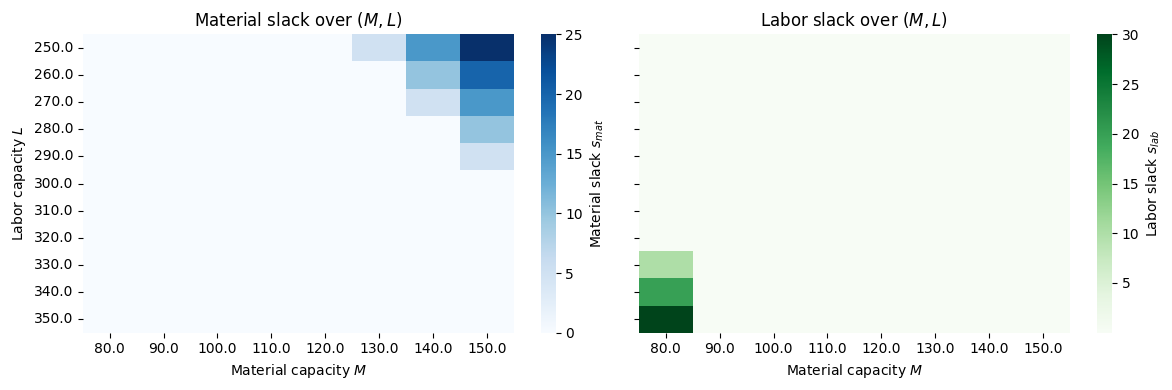

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

heat_mat = slack_table.pivot(index="L", columns="M", values="slack_material")
heat_lab = slack_table.pivot(index="L", columns="M", values="slack_labor")

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

sns.heatmap(
    heat_mat,
    cmap="Blues",
    annot=False,
    cbar_kws={"label": "Material slack $s_{mat}$"},
    ax=axes[0],
)
axes[0].set_xlabel("Material capacity $M$")
axes[0].set_ylabel("Labor capacity $L$")
axes[0].set_title("Material slack over $(M, L)$")

sns.heatmap(
    heat_lab,
    cmap="Greens",
    annot=False,
    cbar_kws={"label": "Labor slack $s_{lab}$"},
    ax=axes[1],
)
axes[1].set_xlabel("Material capacity $M$")
axes[1].set_ylabel("")  # share y-axis label from left
axes[1].set_title("Labor slack over $(M, L)$")

plt.tight_layout()
plt.show()


## 4. Objective Coefficient Sensitivity

We now keep the resource capacities fixed at their baseline values
$$
M = 100, \qquad L = 300,
$$
and treat the profit coefficients $c_1$ and $c_2$ as parameters. The parametric family of problems is
$$
\max\ c_1 x_1 + c_2 x_2
$$
subject to
$$
x_1 + x_2 \le 100, \qquad
2x_1 + 4x_2 \le 300, \qquad
x_1, x_2 \ge 0.
$$

For each pair $(c_1, c_2)$ in a specified coefficient range (for example, $c_1 \in [4,8]$, $c_2 \in [7,11]$), we solve this LP and record the optimal solution $(x_1^*, x_2^*)$ and the optimal objective value. This produces an empirical map of how the optimal activity levels respond to changes in the profit coefficients.

More concretely, we can define a grid of coefficient values and evaluate the model at each grid point:
$$
c_1 \in \{c_1^{(1)}, \dots, c_1^{(K)}\}, \qquad
c_2 \in \{c_2^{(1)}, \dots, c_2^{(J)}\},
$$
and for each $(c_1^{(k)}, c_2^{(j)})$ solve
$$
\max\ c_1^{(k)} x_1 + c_2^{(j)} x_2
$$
subject to the fixed constraints above. The resulting optimal solutions are denoted by
$$
x_1^*(c_1^{(k)}, c_2^{(j)}), \qquad
x_2^*(c_1^{(k)}, c_2^{(j)}).
$$

In [16]:
c1_min, c1_max = param_ranges["c1"]
c2_min, c2_max = param_ranges["c2"]

c1_vals = np.linspace(c1_min, c1_max, 9)
c2_vals = np.linspace(c2_min, c2_max, 9)

rows = []
for c1 in c1_vals:
    for c2 in c2_vals:
        res = solve_production(
            c1=c1,
            c2=c2,
            M=baseline_params["M"],
            L=baseline_params["L"],
        )
        if res["status"] == "optimal":
            rows.append({
                "c1": c1,
                "c2": c2,
                "x1": res["x1"],
                "x2": res["x2"],
                "value": res["value"],
            })

coef_table = pd.DataFrame(rows)
coef_table.head()

,c1,c2,x1,x2,value
0,4.0,7.0,50.000000,50.000000,550.000000
1,4.0,7.5,49.999994,50.000003,574.999998
2,4.0,8.0,26.619852,61.690074,600.000000
3,4.0,8.5,0.000011,74.999995,637.499997
4,4.0,9.0,0.000003,74.999999,674.999999


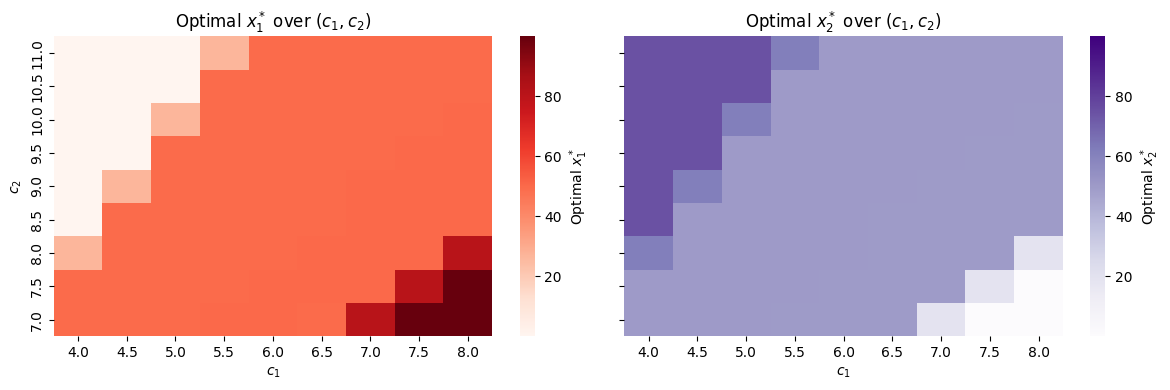

In [36]:
x1_grid = coef_table.pivot(index="c2", columns="c1", values="x1")
x2_grid = coef_table.pivot(index="c2", columns="c1", values="x2")

vmin = min(coef_table.x1.min(), coef_table.x2.min())
vmax = max(coef_table.x1.max(), coef_table.x2.max())


fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

sns.heatmap(
    x1_grid,
    cmap="Reds",
    annot=False,
    cbar_kws={"label": "Optimal $x_1^*$"},
    ax=axes[0],
    vmin=vmin, vmax=vmax
)
axes[0].invert_yaxis()
axes[0].set_xlabel("$c_1$")
axes[0].set_ylabel("$c_2$")
axes[0].set_title("Optimal $x_1^*$ over $(c_1, c_2)$")

sns.heatmap(
    x2_grid,
    cmap="Purples",
    annot=False,
    cbar_kws={"label": "Optimal $x_2^*$"},
    ax=axes[1],
    vmin=vmin, vmax=vmax
)
axes[1].invert_yaxis()
axes[1].set_xlabel("$c_1$")
axes[1].set_ylabel("")
axes[1].set_title("Optimal $x_2^*$ over $(c_1, c_2)$")

plt.tight_layout()
plt.show()

## 5. Parametric Optimization over finer steps


In [30]:
c1_vals = np.linspace(c1_min, c1_max, 200)
c2_vals = np.linspace(c2_min, c2_max, 200)

print(f"Total number of scenarios: {c1_vals.size * c2_vals.size}")

Total number of scenarios: 40000


In [26]:
from tqdm.notebook import tqdm

rows = []
for c2 in tqdm(c2_vals):
    for c1 in c1_vals:
        res = solve_production(c1=c1, c2=c2, M=100, L=300)
        rows.append({
            "c1": c1,
            "c2": c2,
            "status": res["status"],
            "value": res["value"],
            "x1": res["x1"],
            "x2": res["x2"],
            "slack_material": res["slack_material"],
            "slack_labor": res["slack_labor"],
        })

coef_df = pd.DataFrame(rows)


  0%|          | 0/200 [00:00<?, ?it/s]

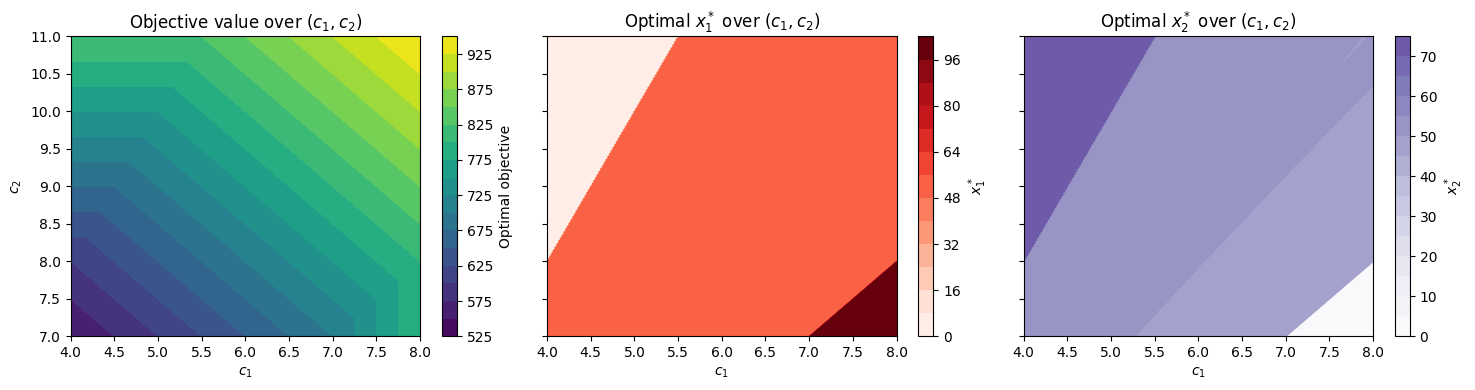

In [35]:
Z_val = coef_df.pivot(index="c2", columns="c1", values="value").values
Z_x1  = coef_df.pivot(index="c2", columns="c1", values="x1").values
Z_x2  = coef_df.pivot(index="c2", columns="c1", values="x2").values

C1, C2 = np.meshgrid(c1_vals, c2_vals)
vmin = min(Z_x1.min(), Z_x2.min())
vmax = max(Z_x1.max(), Z_x2.max())

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)

cs0 = axes[0].contourf(C1, C2, Z_val, levels=15, cmap="viridis")
plt.colorbar(cs0, ax=axes[0], label="Optimal objective")
axes[0].set_title("Objective value over $(c_1, c_2)$")
axes[0].set_xlabel("$c_1$")
axes[0].set_ylabel("$c_2$")

cs1 = axes[1].contourf(C1, C2, Z_x1, levels=15, cmap="Reds",
                       vmin=vmin, vmax=vmax)
plt.colorbar(cs1, ax=axes[1], label="$x_1^*$")
axes[1].set_title("Optimal $x_1^*$ over $(c_1, c_2)$")
axes[1].set_xlabel("$c_1$")

cs2 = axes[2].contourf(C1, C2, Z_x2, levels=15, cmap="Purples",
                       vmin=vmin, vmax=vmax)
plt.colorbar(cs2, ax=axes[2], label="$x_2^*$")
axes[2].set_title("Optimal $x_2^*$ over $(c_1, c_2)$")
axes[2].set_xlabel("$c_1$")

plt.tight_layout()
plt.show()